In [39]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import math

In [40]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [41]:
np.random.seed(0)
torch.manual_seed(0)

In [42]:
def get_state(curr_state, drift, days, action):
    """
    Calculate the next state based on the current state and drift.
    """
    if action==1:
        return 2*drift*days+1
    delta = np.random.uniform(-drift, drift)
    return max(0, min(curr_state + delta, 2 * days * drift))

In [43]:
def get_reward(curr_state, action, days, drift, start_price, strike_price):
    """
    Calculate the reward based on the current state and action.
    """
    if action == 0:
        return 0
    else:
        return curr_state - days * drift + start_price - strike_price

In [44]:
class ActorCritic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(ActorCritic, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.input_activation = nn.LeakyReLU()

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            layer = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(layer)
            self.hidden_layers.append(nn.LeakyReLU())

        # Output layer
        self.output_layer_value = nn.Linear(hidden_size, 1)
        self.output_activation_value = nn.Identity()

        self.output_layer_policy = nn.Linear(hidden_size,output_size)
        self.output_activation_policy = nn.Softmax(dim=-1)

    def forward(self, state):
        x = self.input_layer(state)
        x = self.input_activation(x)
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        value = self.output_layer_value(x)
        value = self.output_activation_value(value)

        policy = self.output_layer_policy(x)
        policy = self.output_activation_policy(policy)
        return value, policy

In [45]:
# Define the input and output sizes
input_size = 2 # Size of your state representation
output_size = 2  # Number of actions (exercise or not exercise)

In [46]:
hidden_size = 64 # Example hidden layer size
num_hidden_layers = 4  # Example number of hidden layers
agent = ActorCritic(input_size, hidden_size, output_size, num_hidden_layers).to(device)

# Define the optimizer
optimizer = optim.Adam(agent.parameters(), lr=1e-5)

In [47]:
T = 5  # Number of time steps
drift = 5
start_price = 500
strike_price = 505

In [48]:
start_states=[]
loss_arr=[]
reward_arr=[]

In [49]:
def print_policy(model, drift, start_price, strike_price, T):
    policy = []  # Dictionary to store policy for each time-price pair

    for time in range(T):
        time_policy = []  # Policy for current time
        for price in range(2 * T * drift + 1):
            # Move input data to GPU
            state = torch.tensor([price, time], dtype=torch.float32).to(device)
            _, action_probs = model(state.unsqueeze(0))

            time_policy.append(action_probs.argmax().item())
        policy.append(time_policy)

    # Print policy for each time-price pair
    for time, price_policy in enumerate(policy):
        print(f"Time: {time + 1}")
        print(price_policy)
    
    optimal_policy=[]
    for time,price_policy in enumerate(policy):
        for i,price in enumerate(price_policy):
            if(price==1):
                optimal_policy.append(i-T*drift+start_price)
                break
    
    return optimal_policy

In [63]:
def find_threshold(model, drift, start_price, strike_price, T):
    thresholds = []  # List to store thresholds for each time

    for time in range(T):
        # Binary search to find the threshold
        left = 0
        right = start_price + 2* T * drift
        while right-left>=0.01:
            mid = (left + right) / 2
            state = torch.tensor([mid, time], dtype=torch.float32).unsqueeze(0)
            _,action_probs = model(state)
            if action_probs.argmax().item() == 1:
                right=mid
            else:
                left = mid
        thresholds.append(left - T*drift + start_price)
    return thresholds


In [51]:
def actor_critic(num_episodes, days=T, drift=drift, start_price=500, strike_price=505, df=0.99):
    for episode in range(num_episodes):
        curr_state = np.random.randint(0,2*days*drift+1)
        time = np.random.randint(0,days)
        start_states.append((curr_state, time))
        reward_curr=0
        done = False
        while not done:
            state_tensor = torch.from_numpy(np.array([curr_state, time], dtype=np.float32))
            state_value, action_probs = agent(state_tensor.unsqueeze(0))  
            # print(action_probs)
            if np.random.uniform() < action_probs[0][0].item():
                action = 0
            else:
                action = 1

            next_state = get_state(curr_state, drift, days, action)
            reward = get_reward(curr_state, action, days, drift, start_price, strike_price)
            reward_curr += reward * math.pow(df, time - start_states[-1][1])

            if time == days or action == 1:
                done = True

            curr_state = next_state
            time += 1
            reward = torch.tensor(reward, dtype=torch.float32)
            new_state_tensor = torch.from_numpy(np.array([next_state, time], dtype=np.float32))
            new_state_value, _ = agent(new_state_tensor.unsqueeze(0))  

            log_prob = torch.log(action_probs[0][action])
            delta = reward  + df*new_state_value*(1-int(done)) - state_value
            actor_loss = -log_prob*delta
            critic_loss = delta**2

            total_loss= actor_loss + critic_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            loss_arr.append(total_loss.item())
        
        if(episode%1000==0):
            print("Episode ",episode)
            optimal_policy=find_threshold(agent, drift, start_price, strike_price, T)
            print(optimal_policy)
        
        reward_arr.append(reward_curr)

        if (episode+1) % 10000 == 0:
            print(f"Episode: {episode + 1}")

In [52]:
actor_critic(num_episodes=249000)

Episode  0
[1024.9916076660156, 1024.9916076660156, 1024.9916076660156, 1024.9916076660156, 1024.9916076660156]
Episode  1000
[486.59820556640625, 486.6569519042969, 486.9255065917969, 487.0933532714844, 487.20245361328125]
Episode  2000
[483.0986022949219, 483.7615966796875, 484.5420837402344, 485.1631164550781, 485.6414794921875]
Episode  3000
[484.44976806640625, 486.83319091796875, 489.5439147949219, 492.0448303222656, 494.4450378417969]
Episode  4000
[488.34381103515625, 493.11065673828125, 498.7419128417969, 504.4822692871094, 510.1387023925781]
Episode  5000
[488.3270263671875, 495.1835632324219, 502.9716491699219, 510.8436584472656, 518.7240600585938]
Episode  6000
[487.1101379394531, 493.5554504394531, 500.8567810058594, 508.4014892578125, 515.95458984375]
Episode  7000
[489.8292541503906, 497.9278564453125, 506.70623779296875, 515.9713745117188, 525.2532958984375]
Episode  8000
[493.04351806640625, 502.77862548828125, 513.0424499511719, 523.5496520996094, 534.48486328125]
Epi

In [64]:
optimal_policy=find_threshold(agent, drift, start_price, strike_price, T)
print(optimal_policy)

[508.3259582519531, 508.01544189453125, 507.5286865234375, 506.90765380859375, 506.03626708984376]


In [65]:
for day, price in enumerate(optimal_policy):
    print(f"Day {day+1} : Price {price}")

Day 1 : Price 508.3259582519531
Day 2 : Price 508.01544189453125
Day 3 : Price 507.5286865234375
Day 4 : Price 506.90765380859375
Day 5 : Price 506.03626708984376


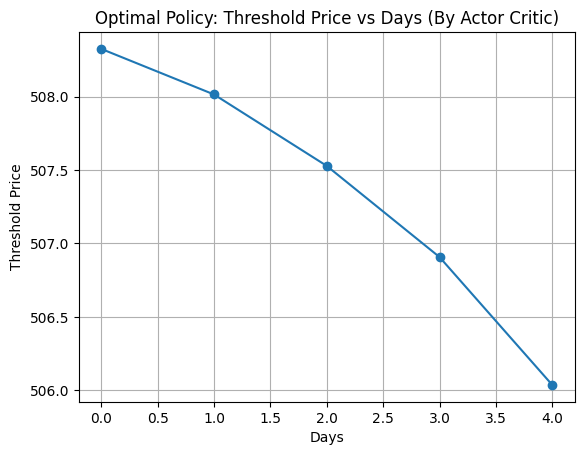

In [66]:
plt.plot(optimal_policy, marker='o')  # Plotting every 100th value
plt.title('Optimal Policy: Threshold Price vs Days (By Actor Critic)')
plt.xlabel('Days')
plt.ylabel('Threshold Price')
plt.grid(True)  # Add grid
plt.show()

In [56]:
for i in range(len(loss_arr)):
    loss_arr[i] = abs(loss_arr[i])

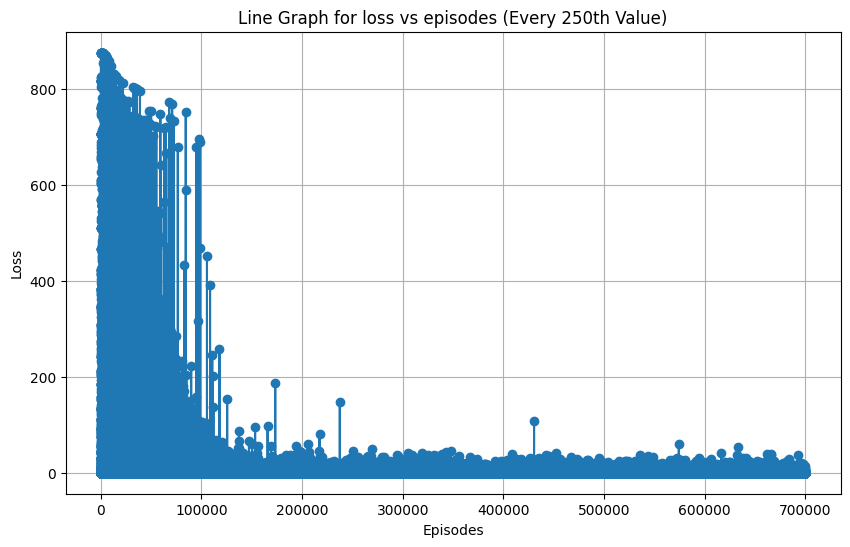

In [57]:
plt.figure(figsize=(10,6))
plt.plot(loss_arr[::1], marker='o')  # Plotting every 100th value
plt.title('Line Graph for loss vs episodes (Every 250th Value)')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.grid(True)  # Add grid
plt.show()

In [58]:
def transition_probability(drift):
    """
    Calculates the transition probability for the given drift.
    """
    return 1 / (2 * drift + 1)

def get_state(drift):
    """
    Generates a random state within the given drift range.
    """
    return np.random.randint(-drift, drift, dtype=int) 

def value_iteration(gamma=0.99):
    """
    Performs value iteration to find the optimal policy.
    """
    start_price, strike_price = 500, 505
    drift = 5  # Change in stock price on each day
    T = 5  # Number of days till expiry

    V = np.zeros((2 * T * drift + 1, T))
    policy = np.zeros((T, 2 * T * drift + 1))

    # Initialize the value function and policy
    for state in range(2 * T * drift + 1):
        V[state][T - 1] = max(0, state - (strike_price - start_price) - T * drift)
        if V[state][T - 1] > 0:
            policy[T - 1][state] = 1

    # Perform value iteration
    for t in reversed(range(T - 1)):
        Q = np.zeros((2 * T * drift + 1, 2))
        for state in range(2 * T * drift + 1):
            for action in [0, 1]:
                new_value = 0.0
                if action == 0:
                    reward = 0
                    for next_state in range(state - drift, state + drift):
                        if 0 <= next_state <= 2 * T * drift:
                            new_value += transition_probability(drift) * (reward + gamma * V[next_state][t + 1])
                else:
                    reward = state - (strike_price - start_price) - T * drift
                    new_value = reward
                Q[state][action] = new_value
            V[state][t] = max(Q[state])
            # Update policy based on Q values
            if Q[state][0] >= Q[state][1]:
                policy[t][state] = 0
            else:
                policy[t][state] = 1
    optimal = []
    for t in range(T):
        for i in reversed(range(2 * T * drift + 1)):
            if policy[t][i] == 0:
                optimal.append(i - T * drift + start_price +1)
                break
    plt.plot(optimal, marker='o')
    plt.title('Optimal Policy: Threshold Price vs Days (By Value Iteration)')
    plt.xlabel('Days')
    plt.ylabel('Threshold Price')
    plt.grid(True)  # Add grid
    plt.show()
    return V

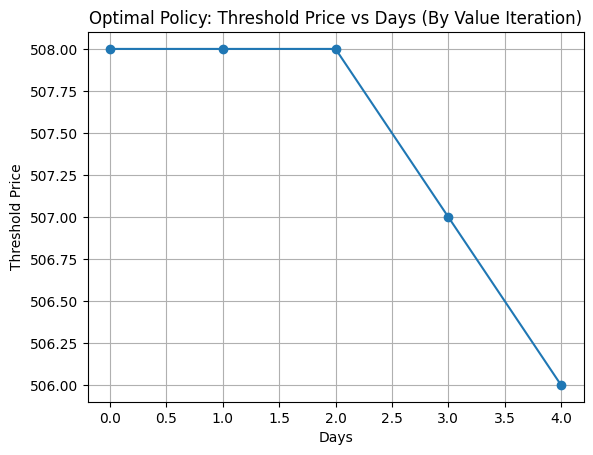

In [59]:
V = value_iteration()

In [60]:
regrets=[]
for i in range(0,len(start_states)):
    regrets.append(V[start_states[i]] - reward_arr[i])

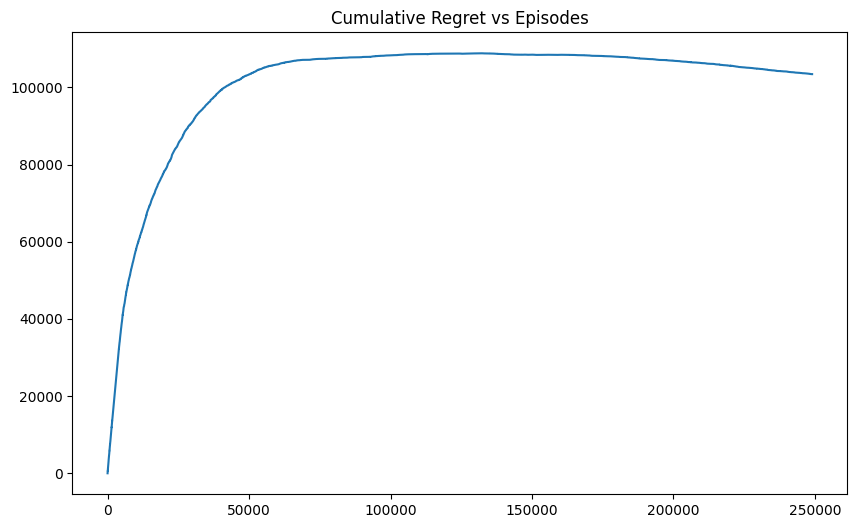

In [61]:
arr_tot = []
for i in range(len(regrets)):
    if(i==0):
        arr_tot.append(regrets[i])
    else:
        arr_tot.append(arr_tot[-1]+regrets[i])

plt.figure(figsize=(10,6))
plt.plot(arr_tot)
plt.title("Cumulative Regret vs Episodes")
plt.show()

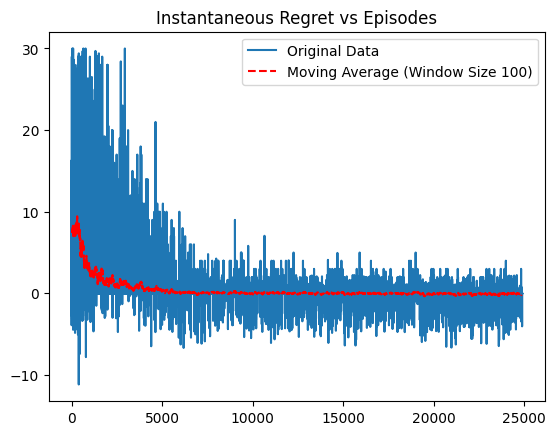

In [62]:
regrets = regrets[::10]
regrets = np.array(regrets)
# regrets = abs(regrets)
# Calculate the moving average using a window size (you can adjust the window size as needed)
window_size = 100
moving_avg = np.convolve(regrets, np.ones(window_size)/window_size, mode='valid')

# Adjusting indices to match the length of moving average
indices = range(window_size//2, len(moving_avg) + window_size//2)

# Plotting the original data
plt.plot(regrets, label='Original Data')

# Plotting the moving average
plt.plot(indices, moving_avg, label=f'Moving Average (Window Size {window_size})', linestyle='--', color='red')

plt.title("Instantaneous Regret vs Episodes")
plt.legend()
plt.show()